## CUSTOMER HAPPINESS

In this notebook, feedback from customers who have received a delivery is utilized to predict which of the questions posed are important in determining what makes a customer happy or unhappy. We will be especially interested in determining what makes a customer unhappy so that corrective action can be made to reduce the proportion of unhappy customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
df.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


Data Description:  
  
Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers  
X1 = my order was delivered on time  
X2 = contents of my order was as I expected  
X3 = I ordered everything I wanted to order  
X4 = I paid a good price for my order  
X5 = I am satisfied with my courier  
X6 = the app makes ordering easy for me  

In [5]:
df.X6.unique() # all features contain ratings which are therefore categorical variables.

array([4, 3, 5, 2, 1], dtype=int64)

In [6]:
df[df['Y']==0]['Y'].count(), df[df['Y']==1]['Y'].count()
# dataset is more or less balanced; 45% are unhappy (Y=0) and 55% are happy (Y=1)

(57, 69)

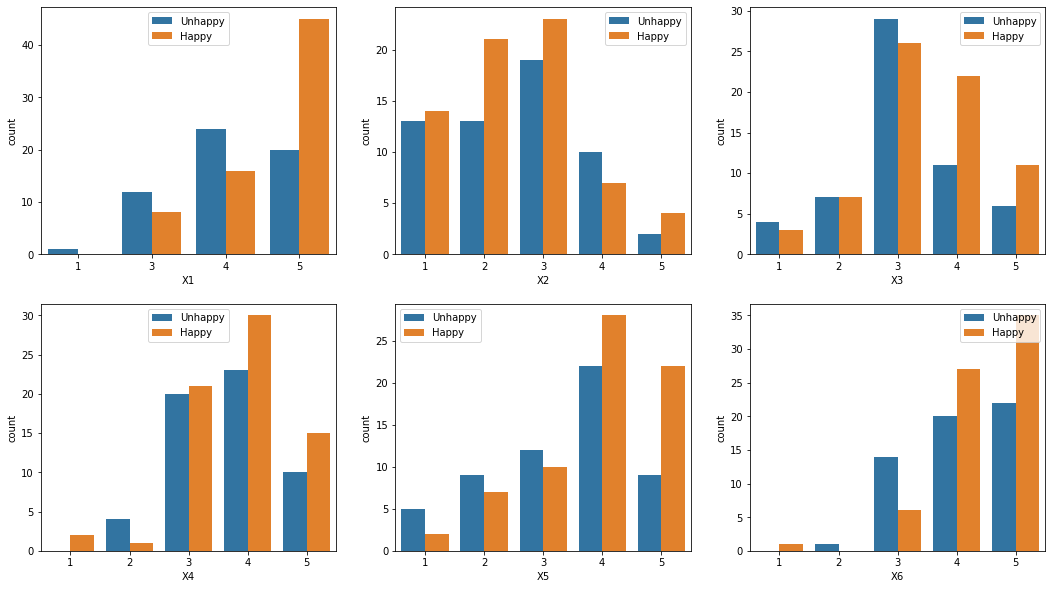

In [7]:
#plot countplots for each survey question (i.e.) question and their ratings. Compare the differences in ratings between happy and
#unhappy customers.

fig, axes = plt.subplots(2,3,figsize=(18,10))
axes = [plot for row in axes for plot in row]
#plt.legend(labels=['Unhappy', 'Happy'])
for ind, feature in enumerate (['X1', 'X2', 'X3', 'X4', 'X5', 'X6']):
    sns.countplot(x=df[feature], hue=df['Y'], ax=axes[ind])
    axes[ind].legend(labels=['Unhappy', 'Happy'])
   

A quick glance at the count plots above indicate that there are no vast differences between happy and unhappy customers, except perhaps at the highest rating of 5 for some of the survey questions.  

## Test Classification by Logistic Regression, Support Vector Machine, Random Forest Classifier and XG Boost Classifier Models

In [8]:
#import libraries for training and testing several ML models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [17]:
#Define a function to sequentially test Logistic Regression, Support Vector, Random Forest Classifier and XG Boost Classifier
# models

def model_sequence(df, rand_state):
    """ 
    Input: Dataframe, random state for train-test split
    Output : Dataframe containining training and testing accuracy scores, precision, recall and f1-score
    Output : Feature importances for the Random Forest and XG Boost models
    """
    X = df.drop('Y', axis=1)
    y = df.Y
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = rand_state)

    score_dict = {'Logistic Regression':{},
                  'Support Vector':{},
                  'Random Forest':{}, 
                  'XG Boost':{}
                 }
    
    def score_dict_edit (key, ML_model):
        ML_model.fit(X_train, y_train)
        train_pred = ML_model.predict(X_train)
        test_pred = ML_model.predict(X_test)
        score_dict[key]['Train Accuracy'] = accuracy_score(y_train, train_pred)
        score_dict[key]['Test Accuracy'] = accuracy_score(y_test, test_pred)
        score_dict[key]['Precision GP 0'] = precision_score(y_test, test_pred, average=None)[0]
        score_dict[key]['Precision GP 1'] = precision_score(y_test, test_pred, average=None)[1]
        score_dict[key]['Recall GP 0'] = recall_score(y_test, test_pred, average=None)[0]
        score_dict[key]['Recall GP 1'] = recall_score(y_test, test_pred, average=None)[1]
        score_dict[key]['F1 Sore GP 0'] = f1_score(y_test, test_pred, average=None)[0]
        score_dict[key]['F1 Sore GP 1'] = f1_score(y_test, test_pred, average=None)[1]


    # create objects for the ML models to be tested 
    model_logreg = LogisticRegression(max_iter=1000, C=1)
    model_SVC=SVC(kernel='rbf', C=5, gamma='auto')
    model_rfc = RandomForestClassifier(n_estimators = 200)
    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.5, max_depth=5)

    models=[model_logreg, model_SVC, model_rfc, model_xgb]

    for model in models:

        if model==model_logreg:
            score_dict_edit ('Logistic Regression', model_logreg)
        elif model==model_SVC:
            score_dict_edit ('Support Vector', model_SVC)
        elif model==model_rfc:
            score_dict_edit ('Random Forest', model_rfc)
        else:
            score_dict_edit ('XG Boost', model_xgb)
    df_metrics=pd.DataFrame(score_dict).transpose()
    rfc_imp = pd.DataFrame({'Feature':X.columns, 'Importance':model_rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
    xgb_imp = pd.DataFrame({'Feature':X.columns, 'Importance':model_xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
    return df_metrics, rfc_imp, xgb_imp

In [18]:
df_metrics, rfc_imp, xgb_imp = model_sequence(df, 5)

In [19]:
df_metrics

,Train Accuracy,Test Accuracy,Precision GP 0,Precision GP 1,Recall GP 0,Recall GP 1,F1 Sore GP 0,F1 Sore GP 1
Logistic Regression,0.659091,0.526316,0.428571,0.583333,0.3750,0.636364,0.400000,0.608696
Support Vector,0.829545,0.631579,0.583333,0.653846,0.4375,0.772727,0.500000,0.708333
Random Forest,0.943182,0.631579,0.571429,0.666667,0.5000,0.727273,0.533333,0.695652
XG Boost,0.931818,0.578947,0.500000,0.625000,0.4375,0.681818,0.466667,0.652174


In the above table of metrics we can see that there is overfitting with all of the models tested. This is especially pronounced for Random Forest and XGBoost algorithms. # The recall and f1-scores for group 0 (unhappy) customers are only 0.5 and 0.53 respectively. This indicates that the model is having trouble correctly identifying the unhappy customers. We would want to know the reasons why a customer is unhappy so that changes can be made to retain them. Therefore, I will try to examine whether we can remove un necessary features in an effort to improve the recall and f1-score for group 0.

In [20]:
# Check feature importances of the Random Forest model
rfc_imp

,Feature,Importance
1,X2,0.204033
4,X5,0.203743
2,X3,0.191283
0,X1,0.136338
3,X4,0.136094
5,X6,0.128510


In [21]:
# Check feature importances of the XG Boost model
xgb_imp

,Feature,Importance
2,X3,0.200417
4,X5,0.200328
0,X1,0.176122
1,X2,0.173256
3,X4,0.136417
5,X6,0.113461


In [14]:
df2 = df.drop(['X6'], axis=1)
# Drop X6 (usefulness of the app), which surprisingly, appears to be the least important feature.
# Create a new dataframe df2 with just the single feature X6 being droppped

In [22]:
df_metrics2, rfc_imp2, xgb_imp2 = model_sequence(df2, 3)

In [23]:
df_metrics2

,Train Accuracy,Test Accuracy,Precision GP 0,Precision GP 1,Recall GP 0,Recall GP 1,F1 Sore GP 0,F1 Sore GP 1
Logistic Regression,0.534091,0.657895,0.700000,0.642857,0.411765,0.857143,0.518519,0.734694
Support Vector,0.795455,0.578947,0.533333,0.608696,0.470588,0.666667,0.500000,0.636364
Random Forest,0.886364,0.710526,0.750000,0.692308,0.529412,0.857143,0.620690,0.765957
XG Boost,0.886364,0.763158,0.750000,0.772727,0.705882,0.809524,0.727273,0.790698


In [25]:
from sklearn.model_selection import GridSearchCV

In [36]:
X = df2.drop('Y', axis=1)
y = df2.Y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 5)

In [37]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [38]:
params = { 'max_depth': [3,5, 6],
           'learning_rate': [0.01, 0.5, 0.6, 0.7],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.7, 0.8, 0.9]}

clf = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(X,y)

print("Best parameters:", clf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [39]:
#train a new xgb model with the best parameters
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 3, n_estimators = 100)

xgb2.fit(X_train, y_train)
print('Test Accuracy:', xgb2.score(X_test, y_test))
print('Train Accuracy:',xgb2.score(X_train, y_train))

Test Accuracy: 0.5526315789473685
Train Accuracy: 0.6818181818181818


In [40]:
#surprisingly, the 'best parameters' did not yield metrics better than what worked with this model previously. Why is that?
pred = xgb2.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.48      0.62      0.54        16
           1       0.65      0.50      0.56        22

    accuracy                           0.55        38
   macro avg       0.56      0.56      0.55        38
weighted avg       0.58      0.55      0.55        38

[[10  6]
 [11 11]]


## Concluding Remarks

Even though the overall accuracy is the same as when the Random Forest Classifier was used, the recall and f1-scores for group 0 (unhappy) customers have significantly improved indicating that the XG Boost model fares better in identifying unhappy customers. Hyperparameter tuning attempt did not yield parameters that could further improve the model's performance. 

Therefore, I concluded that XG Boost model fares better than a Random Forest model for this particular dataset in predicting customer happiness.  Based on the results, the question X6 (the app makes ordering easy for me) can be excluded in the future from the questionnaire.